In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", path)

100%|██████████| 48.6k/48.6k [00:00<00:00, 187kB/s]

Extracting model files...
Path to dataset files: C:\Users\OMEN\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2


In [6]:
# 1) Setup: libraries, style, configuration (customize here)
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 4)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_curve,
    roc_auc_score, roc_curve, auc
)

# Customizable input path (UCI Breast Cancer Wisconsin Diagnostic dataset via KaggleHub cache)
INPUT_CSV = r"C:\Users\OMEN\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2\data.csv"  # <-- given path

# Output toggle and path (optional)
EXPORT_MATRIX = False
OUTPUT_MATRIX = "logreg_breast_cancer_model_matrix.csv"

assert os.path.exists(INPUT_CSV), f"File not found: {INPUT_CSV}"


In [7]:
# 2) Load data and curate target/features for Breast Cancer dataset
# The dataset typically has columns: id, diagnosis (M/B), 30 feature columns, and an empty 'Unnamed: 32' to drop.

df = pd.read_csv(INPUT_CSV)

# Drop unnamed or fully empty columns safely
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]

# Map diagnosis: M=1 (malignant), B=0 (benign)
assert "diagnosis" in df.columns, "Expected 'diagnosis' column not found."
y = df["diagnosis"].map({"M": 1, "B": 0}).astype(int).values

# Drop non-feature identifier columns like 'id' and the target
drop_cols = [c for c in ["id", "diagnosis"] if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore")

print("Data shape:", df.shape)
print("X shape:", X.shape, "| y shape:", y.shape)
print("Positive class rate (malignant=1):", y.mean().round(4))


Data shape: (569, 32)
X shape: (569, 30) | y shape: (569,)
Positive class rate (malignant=1): 0.3726


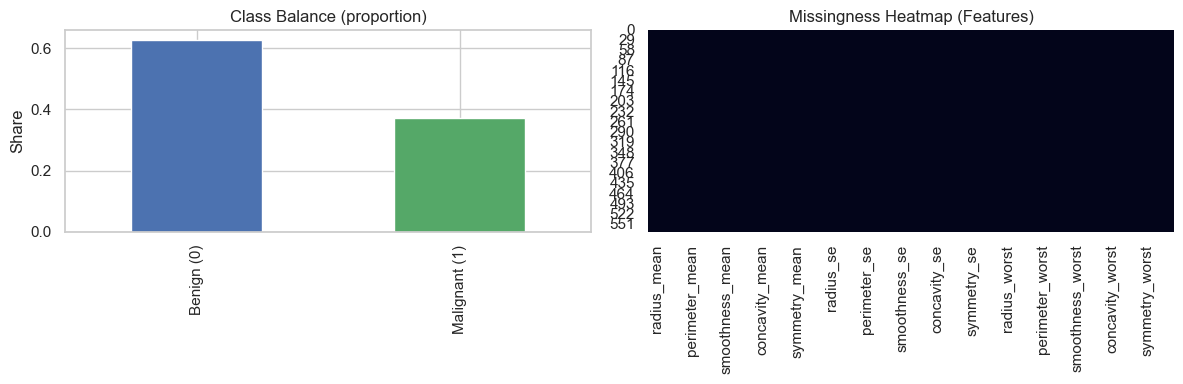

In [8]:
# 3) Quick EDA: class balance and missingness
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Class balance
(pd.Series(y).value_counts(normalize=True)
   .sort_index()
   .rename({0: "Benign (0)", 1: "Malignant (1)"})
   .plot(kind="bar", ax=ax[0], color=["#4C72B0", "#55A868"]))
ax[0].set_title("Class Balance (proportion)")
ax[0].set_ylabel("Share")

# Missingness heatmap (should be none for this dataset, but visualize anyway)
sns.heatmap(X.isna(), cbar=False, ax=ax[1])
ax[1].set_title("Missingness Heatmap (Features)")
plt.tight_layout()
plt.show()


In [9]:
# 4) Train/test split (stratified) and preprocessing definition
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# Identify column types
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()  # likely empty here

# Preprocessing: numeric median impute + StandardScaler; categorical most_frequent + OHE (safe even if empty)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


Train/Test shapes: (455, 30) (114, 30)


In [10]:
# 5) Model training: Logistic Regression in a single Pipeline
# This matches scikit-learn's recommended API for linear models and ensures no data leakage from preprocessing. 
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

log_reg.fit(X_train, y_train)
print("Model trained.")


Model trained.


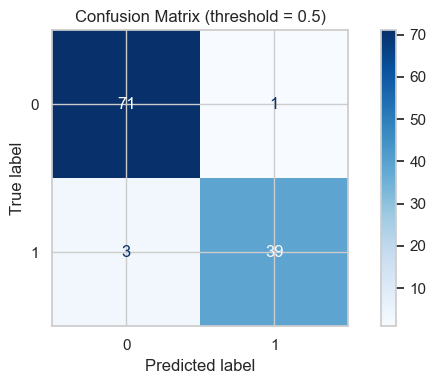

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC-AUC: 0.9960


In [11]:
# 6) Default threshold evaluation (0.5): confusion matrix, report, ROC-AUC
y_proba = log_reg.predict_proba(X_test)[:, 1]         # probability for positive class
y_pred05 = (y_proba >= 0.5).astype(int)               # default 0.5 threshold

# Confusion matrix
cm = confusion_matrix(y_test, y_pred05)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (threshold = 0.5)")
plt.tight_layout()
plt.show()

# Classification report (precision/recall/F1)
print("Classification Report (threshold = 0.5):")
print(classification_report(y_test, y_pred05))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")


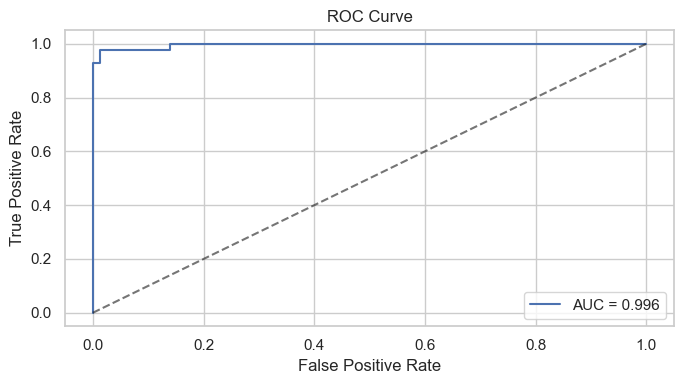

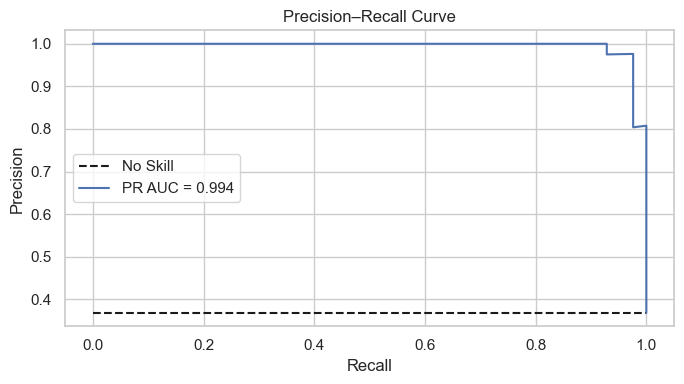

In [12]:
# 7) ROC and Precision–Recall curves for threshold-independent diagnostics

# ROC curve
fpr, tpr, roc_thr = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall curve (useful if class balance is skewed)
prec, rec, pr_thr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)
no_skill = np.mean(y_test == 1)
plt.plot([0, 1], [no_skill, no_skill], "k--", label="No Skill")
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


Best F1: 0.9762 at threshold 0.24


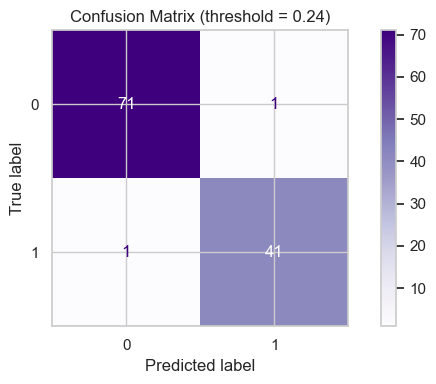

Classification Report (best F1 threshold):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [13]:
# 8) Threshold tuning: maximize F1 across thresholds in [0,1]
best_f1, best_thr = -1.0, 0.5
for thr in np.linspace(0.0, 1.0, 101):
    y_thr = (y_proba >= thr).astype(int)
    tp = np.sum((y_test == 1) & (y_thr == 1))
    fp = np.sum((y_test == 0) & (y_thr == 1))
    fn = np.sum((y_test == 1) & (y_thr == 0))
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.0
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"Best F1: {best_f1:.4f} at threshold {best_thr:.2f}")

# Evaluate at best threshold
y_best = (y_proba >= best_thr).astype(int)
cm_best = confusion_matrix(y_test, y_best)
ConfusionMatrixDisplay(confusion_matrix=cm_best).plot(cmap="Purples", values_format="d")
plt.title(f"Confusion Matrix (threshold = {best_thr:.2f})")
plt.tight_layout()
plt.show()

print("Classification Report (best F1 threshold):")
print(classification_report(y_test, y_best))


In [14]:
# 9) Optional: export model-ready numeric matrix with feature names
if EXPORT_MATRIX:
    Xt = log_reg.named_steps["preprocess"].transform(X)
    if hasattr(Xt, "toarray"):
        Xt = Xt.toarray()

    # Recover feature names: numeric + OHE categories
    feature_names = []
    feature_names += num_cols
    if cat_cols:
        ohe = log_reg.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
        feature_names += ohe.get_feature_names_out(cat_cols).tolist()

    model_df = pd.DataFrame(Xt, columns=feature_names, index=X.index)
    model_df["diagnosis"] = y  # keep the mapped target for reference
    model_df.to_csv(OUTPUT_MATRIX, index=False)
    print("Saved model matrix to:", OUTPUT_MATRIX)
